In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "/Users/user/git/eli5/")
import eli5

sys.path.insert(0, "/Users/user/git/datasci")
from sci.metrics import rmse_score
from plots import *
import sci.features as scif
import sci.learn as scil
import sci.plots as scip
import sci.base as scib

import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting floats output to
pd.options.display.max_rows = 999

import numpy as np

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


modified eli5
modified PermutationImportance sklearn


/Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


## Load Data

In [2]:
# raw data
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

df_train = df_train.set_index("PassengerId")
df_test = df_test.set_index("PassengerId")

y = df_train["Survived"]
X = df_train.drop('Survived', axis=1)

print(y.shape)
print(df_train.shape)
print(X.shape)
print(df_test.shape)

(891,)
(891, 11)
(891, 10)
(418, 10)


In [3]:
scif.df_summary(df_train)

,count,missing,percent,dtype,types,uniq,values,freq
Cabin,204,687,77.1044,object,str,147,"A10, A14, A16, A19, A20, A23, A24, A26, ...","'C23 C25 C27':4, 'G6':4, 'B96 B98':4, 'D':..."
Age,714,177,19.8653,float64,float,88,"0.42, 0.67, 0.75, 0.83, 0.92, 1.0, 2.0, ...","'24.0':30, '22.0':27, '18.0':26, '19.0':25..."
Embarked,889,2,0.2245,object,str,3,"C, Q, S","'S':644, 'C':168, 'Q':77..."
Survived,891,0,0.0000,int64,int,2,"0, 1","'0':549, '1':342..."
Pclass,891,0,0.0000,int64,int,3,"1, 2, 3","'3':491, '1':216, '2':184..."
Name,891,0,0.0000,object,str,891,"Abbing, Mr. Anthony, ...","'Rice, Master. Eric':1, 'Allison, Master..."
Sex,891,0,0.0000,object,str,2,"female, male","'male':577, 'female':314..."
SibSp,891,0,0.0000,int64,int,7,"0, 1, 2, 3, 4, 5, 8","'0':608, '1':209, '2':28, '4':18, '3':16, '8..."
Parch,891,0,0.0000,int64,int,7,"0, 1, 2, 3, 4, 5, 6","'0':678, '1':118, '2':80, '5':5, '3':5, '4':..."
Ticket,891,0,0.0000,object,str,681,"110152, 110413, 110465, 110564, 110813, ...","'347082':7, 'CA. 2343':7, '1601':7, '34708..."


## Process

In [181]:
def get_deck(cabin):
    if pd.isnull(cabin):
        return np.nan
    return cabin.split(" ")[-1][0]

def MungeData(df):
    df = df.copy()
    
    df["FamilyName"] = df.Name.apply(lambda x: x.split(", ")[0])
    df["Title"] = df.Name.apply(lambda x: x.split(", ")[1].split(" ")[0])
     
    df["is_child"] = df.Age < 18
    df.loc[df.Age.isnull(), "is_child"] = (df["Title"] == 'Miss.') | (df["Title"] == 'Master.')

    #     df["is_woman"] = (df["Title"] == 'Miss.') | (df["Title"] == 'Mrs.')
    df["is_woman"] = df["Sex"] == "female"

    df["is_woman_or_child"] = df["is_child"] | df["is_woman"]

    df["group_size"] = df['SibSp'] + df['Parch'] + 1
#     df["is_alone"] = df["family_size"] == 1

    df["Age"] = scif.impute_iterative(df)["Age"]
    
#     df.drop(['Ticket'], axis=1, inplace=True)
    df.drop(['Cabin', 'Embarked', 'Title', 'Sex', 'Name'], axis=1, inplace=True)
    df.drop(['Pclass', 'Fare', 'Parch', 'SibSp'], axis=1, inplace=True)
    
    return df

df_train_proc = MungeData(df_train)
df_test_proc = MungeData(df_test)

In [182]:
scif.df_summary(df_train_proc)

,count,missing,percent,dtype,types,uniq,values,freq
Survived,891,0,0.0000,int64,int,2,"0, 1","'0':549, '1':342..."
Age,891,0,0.0000,float64,float,194,"0.42, 0.67, 0.75, 0.83, 0.92, 1.0, 2.0, ...","'24.0':30, '22.0':27, '18.0':26, '19.0':25..."
Ticket,891,0,0.0000,object,str,681,"110152, 110413, 110465, 110564, 110813, ...","'347082':7, 'CA. 2343':7, '1601':7, '34708..."
FamilyName,891,0,0.0000,object,str,667,"Abbing, Abbott, Abelson, Adahl, Adams, ...","'Andersson':9, 'Sage':7, 'Goodwin':6, 'Joh..."
is_child,891,0,0.0000,bool,bool,2,"False, True","'false':738, 'true':153..."
is_woman,891,0,0.0000,bool,bool,2,"False, True","'false':577, 'true':314..."
is_woman_or_child,891,0,0.0000,bool,bool,2,"False, True","'false':515, 'true':376..."
group_size,891,0,0.0000,int64,int,9,"1, 2, 3, 4, 5, 6, 7, 8, 11","'1':537, '2':161, '3':102, '4':29, '6':22, '..."


In [215]:
df_train_proc

,Survived,Age,Ticket,FamilyName,is_child,is_woman,is_woman_or_child,group_size
PassengerId,,,,,,,,
1,0,22.0000,A/5 21171,Braund,False,False,False,2
2,1,38.0000,PC 17599,Cumings,False,True,True,2
3,1,26.0000,STON/O2. 3101282,Heikkinen,False,True,True,1
4,1,35.0000,113803,Futrelle,False,True,True,2
5,0,35.0000,373450,Allen,False,False,False,1
6,0,30.5769,330877,Moran,False,False,False,1
7,0,54.0000,17463,McCarthy,False,False,False,1
8,0,2.0000,349909,Palsson,True,False,True,5
9,1,27.0000,347742,Johnson,False,True,True,3


## Save

In [184]:
y = df_train_proc["Survived"]
X_train = df_train_proc.drop("Survived", axis=1)
X_score = df_test_proc

In [216]:
path = 'processed_wcg'
!mkdir -p $path
X_train.to_msgpack(f'{path}/X.msgpack')
y.to_msgpack(f'{path}/y.msgpack')
X_score.to_msgpack(f'{path}/X_score.msgpack')

# from sklearn.externals import joblib
# joblib.dump(y_tr, f'{path}/y_tr.joblib')


## Quick Test

In [217]:
import sklearn.utils
from sklearn.linear_model import *

data = scil.load_data(path)
# data = scil.Data(X_train, y)

(891, 7) (891,)


In [218]:
import xgboost
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.pipeline import *
from sklearn.metrics import *

scib.metric_global = accuracy_score
scib.scoring_global = 'accuracy'


In [265]:
from sklearn.base import *

class MyTrans(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.y_fit = y
        df = X.copy()
        df["Survived"] = y

#         family_survive_count = df.groupby("FamilyName")["Survived"].sum()
#         family_survive_count -= df["Survived"].astype(int)
#         family_survive_size = df.groupby("FamilyName")["Survived"].size() - 1
#         family_survive_rate = family_survive_count / family_survive_size
#         family_survive_rate[family_survive_size == 0] = -1
        
        wc_family = df.query("is_woman_or_child == True").groupby("FamilyName")
        wc_family_size = wc_family.size()
        wc_family_survive_count = wc_family["Survived"].sum()
#         wc_family_survive_rate = wc_family_survive_count / wc_family_size
        
        df_rate = pd.DataFrame({
            'wc_family_sz': wc_family_size, 
            'wc_family_cnt': wc_family_survive_count, 
        })

#         index_name = df.index.name or "index"
#         df = df.reset_index().merge(df_rate, how="left", left_on="FamilyName", right_index=True).set_index(index_name)
    
#         zz = df[(df.wc_family_sz <= 1) & (df.is_woman_or_child == True)]
#         gby = zz.groupby("Ticket").filter(lambda g: g.shape[0] >= 2).groupby("Ticket")
#         new_family_names = gby["FamilyName"].transform(lambda x: x.iloc[0])
#         df["FamilyName"] = new_family_names
        
#         wc_family = df.query("is_woman_or_child == True").groupby("FamilyName")
#         wc_family_size = wc_family.size()
#         wc_family_survive_count = wc_family["Survived"].sum()
# #         
#         df_rate = pd.DataFrame({
#             'wc_family_sz': wc_family_size, 
#             'wc_family_cnt': wc_family_survive_count, 
#         })
        
        self.df_rate = df_rate
        return self
    
    def transform(self, X):
        
        cols = [c for c in X.columns if c != 'FamilyName']
#         X = X.copy()
#         X.loc[:, cols] = X[cols].astype(float)

        index_name = X.index.name or "index"
        df_merged = X.reset_index().merge(self.df_rate, how="left", left_on="FamilyName", right_index=True).set_index(index_name)
    
        # we MUST reomve self from the count of the family survival rate, but it's relevant only for the X that was usec in .fit()
        if self.y_fit.shape[0] == X.shape[0] and np.all(self.y_fit.index == X.index):
            df_merged['wc_family_sz'] -= df_merged["is_woman_or_child"]
            df_merged['wc_family_cnt'] -= df_merged["is_woman_or_child"] * self.y_fit

        df_merged['wc_family_SR'] = df_merged["wc_family_cnt"] / df_merged["wc_family_sz"]
        df_merged.loc[df_merged['wc_family_sz'] == 0, 'wc_family_SR'] = -1

        df_merged['wc_family_SR'] = df_merged['wc_family_SR'].fillna(-2)
        df_merged['wc_family_sz'] = df_merged['wc_family_sz'].fillna(0)

        df_merged = df_merged.drop("wc_family_cnt", axis=1)
        df_merged = df_merged.drop("wc_family_sz", axis=1)
        df_merged = df_merged.drop("FamilyName", axis=1)
        df_merged = df_merged.drop("Ticket", axis=1)
        df_merged = df_merged.drop("family_size", axis=1, errors='ignore')
        df_merged = df_merged.drop("group_size", axis=1, errors='ignore')
#         df_merged = df_merged.drop("is_woman_or_child", axis=1)


        df_merged = df_merged.astype(float)
        return df_merged
    
    
class MyModel(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        def f(row):
            if row.is_woman:
                if row.wc_family_SR == 0:
                    return 0
                return 1
            else:
                if row.is_child and row.wc_family_SR == 1:
                    return 1
                return 0
        return X.apply(f, axis=1)
#         return X.apply(lambda x: 1 if x.is_woman else 0, axis=1)
        

from sklearn.tree import *
from sklearn.ensemble import *
base = DecisionTreeClassifier(criterion="gini", splitter="best", max_features=1, min_samples_leaf=10, max_depth=1)
base = DecisionTreeClassifier( min_samples_leaf=10, min_impurity_decrease=0.01)   

tree = DecisionTreeClassifier()   
scil.set_params(tree, **{'decisiontreeclassifier__class_weight': None, 'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_leaf_nodes': 10, 'decisiontreeclassifier__min_impurity_decrease': 9.92786956293173e-06, 'decisiontreeclassifier__min_samples_leaf': 0.00025725147766385704, 'decisiontreeclassifier__min_samples_split': 2.496917871316585e-05, 'decisiontreeclassifier__presort': False, 'decisiontreeclassifier__splitter': 'best'})

xgb = xgboost.XGBClassifier()
scil.set_params(xgb, **{'xgbclassifier__colsample_bylevel': 0.4886494540482622, 'xgbclassifier__colsample_bytree': 0.30084129270654836, 'xgbclassifier__gamma': 2.5783810490722384e-08, 'xgbclassifier__learning_rate': 0.21141921089379107, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 0, 'xgbclassifier__n_estimators': 62, 'xgbclassifier__reg_alpha': 1.475897728145355e-06, 'xgbclassifier__reg_lambda': 2.1741019333450753e-09, 'xgbclassifier__subsample': 0.9114284062203754})

rf = RandomForestClassifier(n_estimators=20)
scil.set_params(rf, **{'randomforestclassifier__bootstrap': True, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': None, 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__min_impurity_decrease': 2.018235244650469e-08,  'randomforestclassifier__min_samples_leaf': 0.0003786763744507726, 'randomforestclassifier__min_samples_split': 1.198762578146924e-05})

bag_tree = BaggingClassifier(DecisionTreeClassifier(), n_estimators=20, max_samples=0.9)

base = xgb
base = MyModel()


pipe = make_pipeline(
    MyTrans(),
    base
)
mm = pipe

In [266]:
xx = scil.pipeline_fit_transform(mm, data.X_train, data.y_train)
xx.head()


# zz = xx[(xx.wc_family_sz == 0) & (xx.is_woman_or_child == True)]
# gby = zz.groupby("Ticket").filter(lambda g: g.shape[0] >= 2).groupby("Ticket")
# new_family_names = gby["FamilyName"].transform(lambda df: df.iloc[0])
# xx["FamilyName"] = new_family_names

# zz = xx[(xx.wc_family_sz == 0) & (xx.is_woman_or_child == True)]
# zz.groupby("Ticket").filter(lambda g: g.shape[0] >= 2)

,Age,is_child,is_woman,is_woman_or_child,wc_family_SR
PassengerId,,,,,
274,37.0000,0.0000,0.0000,0.0000,-2.0000
789,1.0000,1.0000,0.0000,1.0000,-2.0000
238,8.0000,1.0000,1.0000,1.0000,-2.0000
427,28.0000,0.0000,1.0000,1.0000,-2.0000
578,39.0000,0.0000,1.0000,1.0000,-2.0000


In [267]:
# mm.set_params(**{'xgbclassifier__colsample_bylevel': 0.6679621864513076, 'xgbclassifier__colsample_bytree': 0.142393802230616, 'xgbclassifier__gamma': 7.045036299649636e-08, 'xgbclassifier__learning_rate': 0.9223357320766533, 'xgbclassifier__max_depth': 16, 'xgbclassifier__min_child_weight': 9, 'xgbclassifier__n_estimators': 89, 'xgbclassifier__reg_alpha': 1.2433113437953347e-09, 'xgbclassifier__reg_lambda': 0.0027287458551926167, 'xgbclassifier__subsample': 0.9516739148092488})
# mm.set_params(**{'decisiontreeclassifier__class_weight': None, 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_leaf_nodes': 10, 'decisiontreeclassifier__min_impurity_decrease': 4.2337018112636034e-10, 'decisiontreeclassifier__min_impurity_split': 2.1357133232367713e-10, 'decisiontreeclassifier__min_samples_leaf': 0.00040834318913745166, 'decisiontreeclassifier__min_samples_split': 1.069174331096355e-05, 'decisiontreeclassifier__presort': True, 'decisiontreeclassifier__splitter': 'random'})
# mm.set_params(**{'decisiontreeclassifier__class_weight': None, 'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_leaf_nodes': 10, 'decisiontreeclassifier__min_impurity_decrease': 4.2337018112636034e-10, 'decisiontreeclassifier__min_impurity_split': 2.1357133232367713e-10, 'decisiontreeclassifier__min_samples_leaf': 0.00040834318913745166, 'decisiontreeclassifier__min_samples_split': 1.069174331096355e-05, 'decisiontreeclassifier__presort': True, 'decisiontreeclassifier__splitter': 'best'})
# mm.set_params(**{'decisiontreeclassifier__class_weight': None, 'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_leaf_nodes': 10, 'decisiontreeclassifier__min_impurity_decrease': 9.92786956293173e-06, 'decisiontreeclassifier__min_impurity_split': 1.0653313934571837e-10, 'decisiontreeclassifier__min_samples_leaf': 0.00025725147766385704, 'decisiontreeclassifier__min_samples_split': 2.496917871316585e-05, 'decisiontreeclassifier__presort': False, 'decisiontreeclassifier__splitter': 'best'})

scil.fit(data, mm)
scil.score_cv(data, mm, 'accuracy', cv=10)
    

fitting Pipeline ..
CV for Pipeline ..
CV score: 0.787859 +/- 0.0142 SEM


In [153]:
models = [MyModel(), tree, rf, bag_tree, DecisionTreeClassifier(), RandomForestClassifier(), xgb, xgboost.XGBClassifier()]
models = scib._check_models(models, mm)

from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20)

# scil.score_cv(data, models, 'accuracy', cv=cv)


MyModel (0) ..
DecisionTreeClassifier (1) ..
RandomForestClassifier (2) ..
BaggingClassifier (3) ..
DecisionTreeClassifier (4) ..
RandomForestClassifier (5) ..


/Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


XGBClassifier (6) ..
XGBClassifier (7) ..


MyModel (0)                  1.0015
RandomForestClassifier (2)   0.9931
DecisionTreeClassifier (1)   0.9911
XGBClassifier (6)            0.9849
XGBClassifier (7)            0.9820
BaggingClassifier (3)        0.9332
DecisionTreeClassifier (4)   0.9252
RandomForestClassifier (5)   0.8815
Name: ratio, dtype: float64

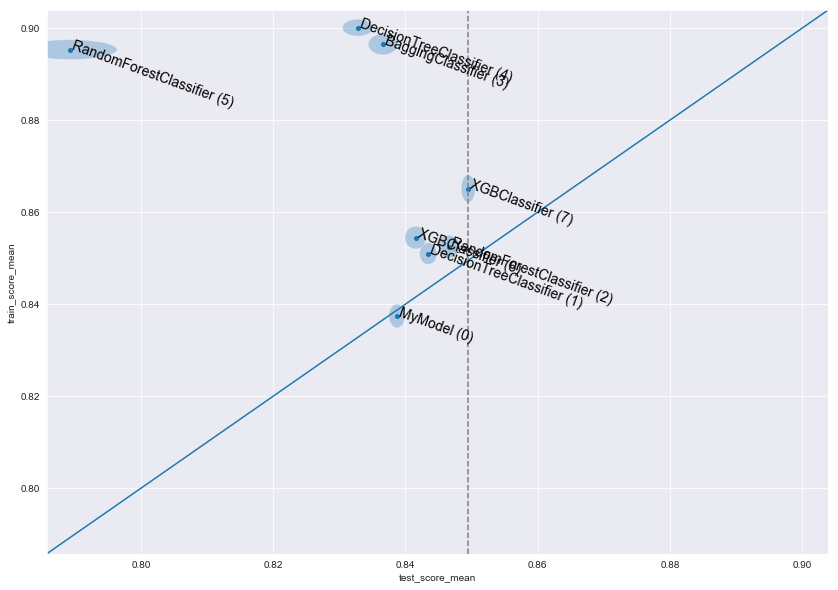

In [154]:
from sklearn.model_selection import StratifiedKFold
scip.models_train_test_scatter_cv(data, models, 'predict', cv=StratifiedKFold(10), n_repeats=10)
# plt.tight_layout()

fitting Pipeline ..


/Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


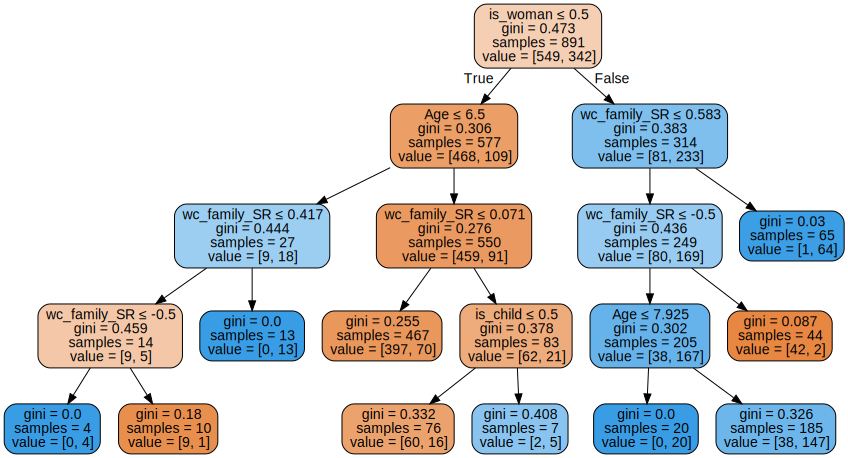

In [76]:
scil.fit(data, mm, all_data=True)
scip.tree_graph(data, mm)

Running 100 iterations of BayesSearchCV with 'accuracy' scoring
with cv = 10
with all_data = False
serach_spaces:
{
    'xgbclassifier__n_estimators': (5, 100),
    'xgbclassifier__learning_rate': (0.001, 1.0, 'log-uniform'),
    'xgbclassifier__max_depth': (1, 20),
    'xgbclassifier__subsample': (0.01, 1.0, 'uniform'),
    'xgbclassifier__gamma': (1e-09, 10, 'log-uniform'),
    'xgbclassifier__min_child_weight': (0, 10),
    'xgbclassifier__reg_lambda': (1e-09, 1000, 'log-uniform'),
    'xgbclassifier__reg_alpha': (1e-09, 1.0, 'log-uniform'),
    'xgbclassifier__colsample_bytree': (0.01, 1.0, 'uniform'),
    'xgbclassifier__colsample_bylevel': (0.01, 1.0, 'uniform'),
}

mean CV 'accuracy' score: 0.6341
params: {'xgbclassifier__colsample_bylevel': 0.8661514900205276, 'xgbclassifier__colsample_bytree': 0.9843410018434992, 'xgbclassifier__gamma': 1.5190913668105241, 'xgbclassifier__learning_rate': 0.0026464784822313255, 'xgbclassifier__max_depth': 10, 'xgbclassifier__min_child_weight': 

/Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


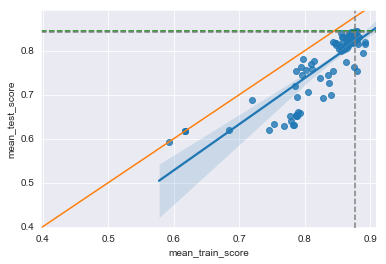

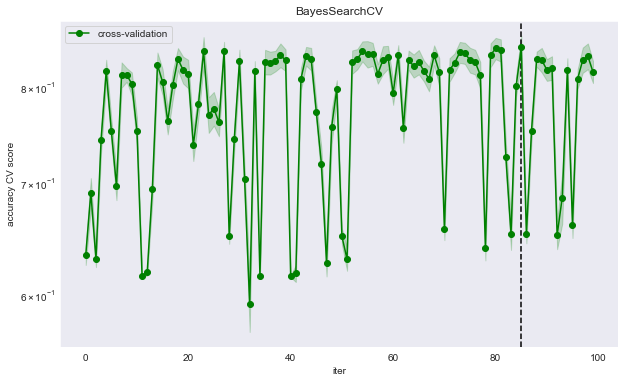

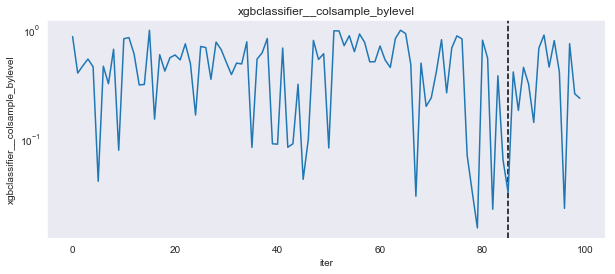

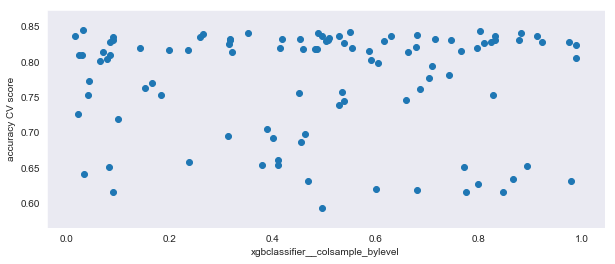

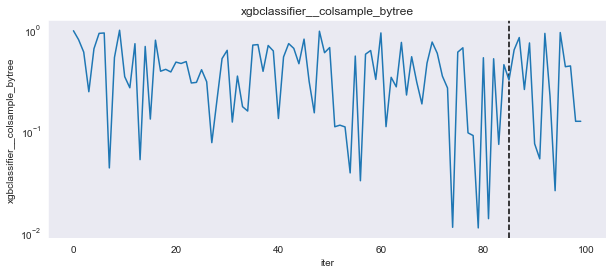

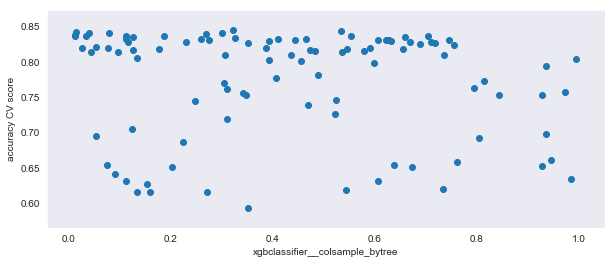

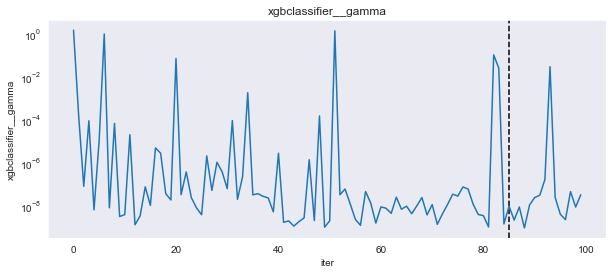

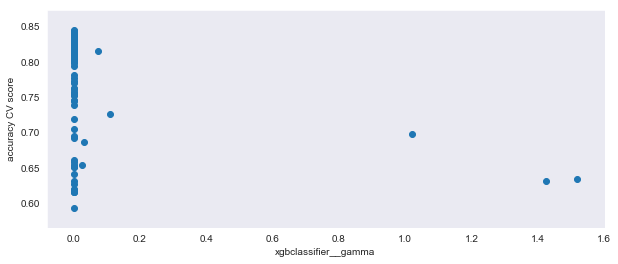

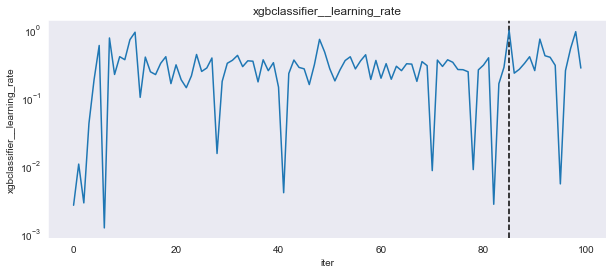

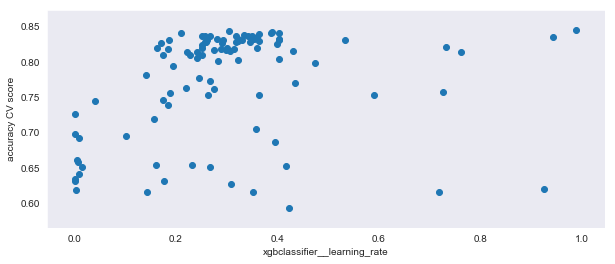

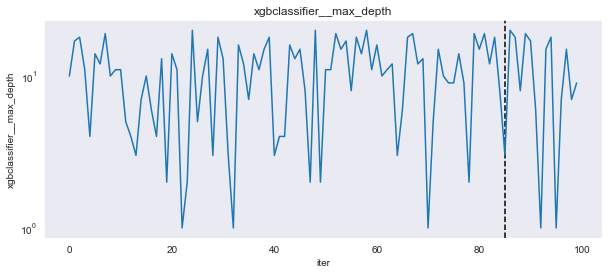

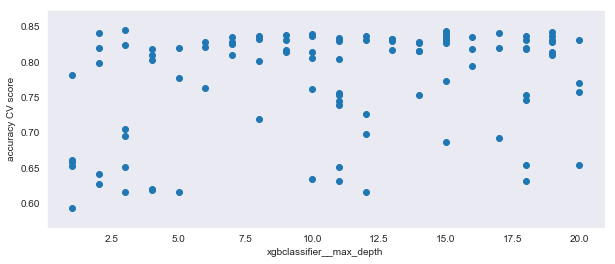

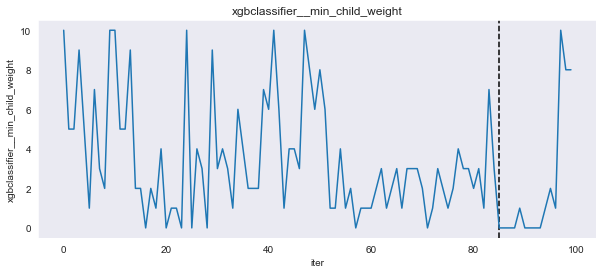

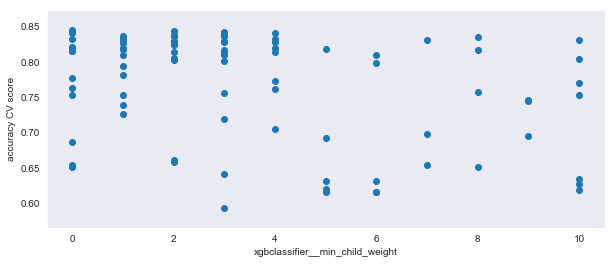

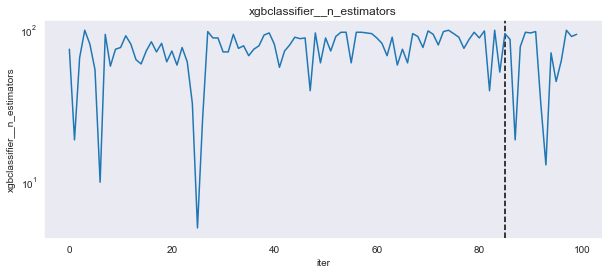

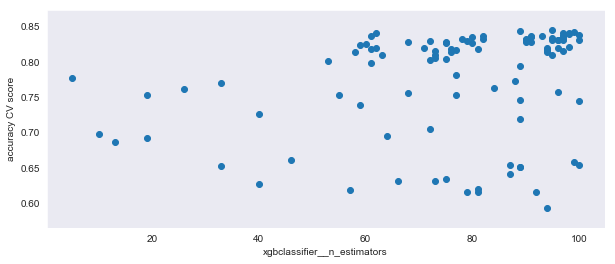

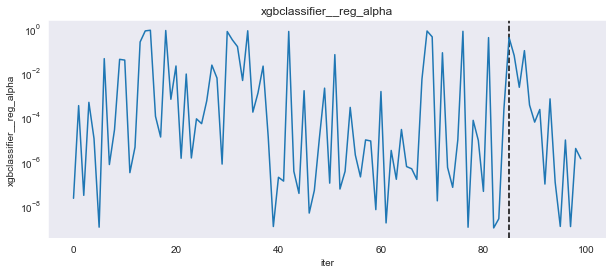

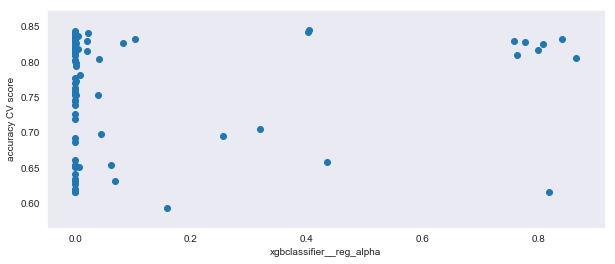

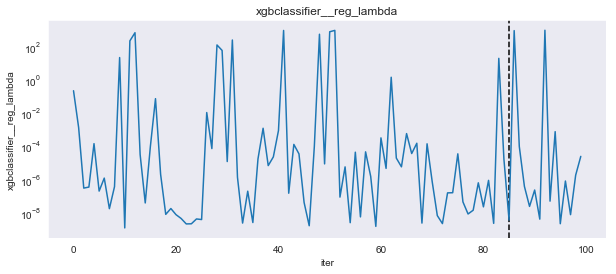

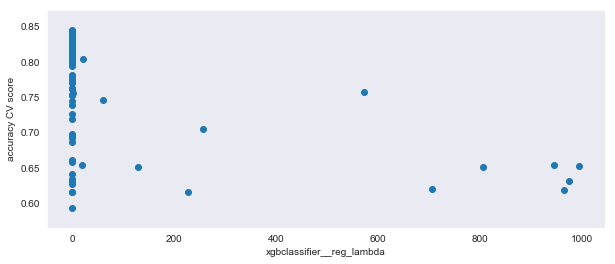

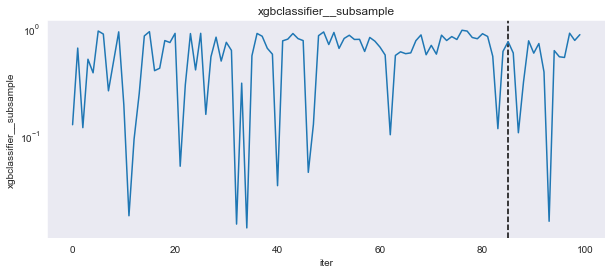

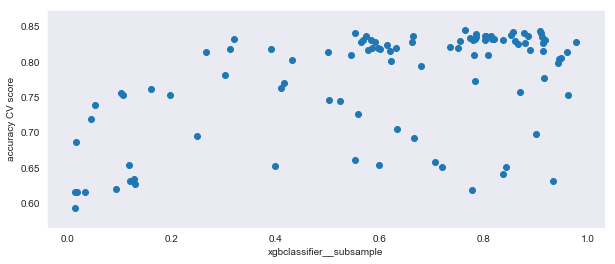

In [114]:
from sklearn.model_selection import *
cv_1000_20 = RepeatedStratifiedKFold(n_splits=20, n_repeats=50)
cv = 10
ss = None

scil.bayes_search(data, mm, 'accuracy', search_spaces=ss, early_stop=None, cv=cv)


=============== best params ================
{'xgbclassifier__colsample_bylevel': 0.032110416732587604, 'xgbclassifier__colsample_bytree': 0.32210975614041226, 'xgbclassifier__gamma': 1.0449114875330238e-08, 'xgbclassifier__learning_rate': 0.9897459259941856, 'xgbclassifier__max_depth': 3, 'xgbclassifier__min_child_weight': 0, 'xgbclassifier__n_estimators': 95, 'xgbclassifier__reg_alpha': 0.4046021884842913, 'xgbclassifier__reg_lambda': 3.671512397594389e-09, 'xgbclassifier__subsample': 0.7652472028674848}

============ good params (at quantile 0.930): ===============
{'xgbclassifier__colsample_bylevel': 0.4886494540482622, 'xgbclassifier__colsample_bytree': 0.30084129270654836, 'xgbclassifier__gamma': 2.5783810490722384e-08, 'xgbclassifier__learning_rate': 0.21141921089379107, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 0, 'xgbclassifier__n_estimators': 62, 'xgbclassifier__reg_alpha': 1.475897728145355e-06, 'xgbclassifier__reg_lambda': 2.1741019333450753e-09, 'x

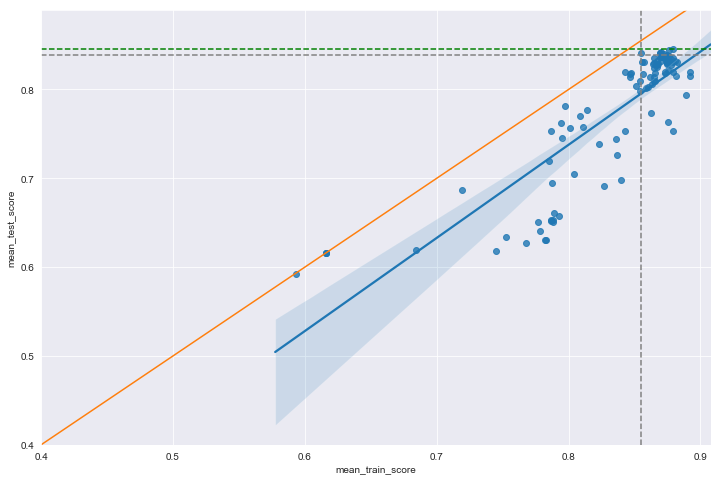

In [119]:
import sci.learn_bayes
scip.bayes_search_results_scatter(sci.learn_bayes.bayes_cv_tuner, mm, good_quantile=0.93)

fitting Pipeline ..
inverse_shuffle base_score: 0.5682 +/- 0.0092


is_woman            53.9683
Age                 25.3968
FamilyName          20.1058
is_woman_or_child    7.9365
is_child            -7.4074
dtype: float64

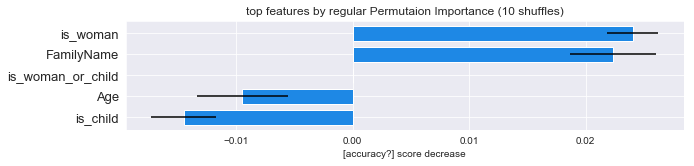

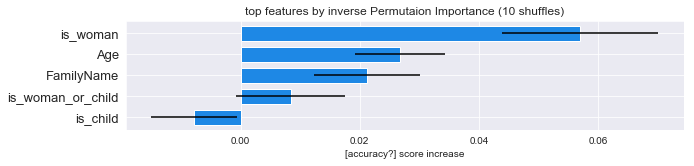

In [146]:
scil.fit(data, mm)
scil.get_top_features_by_permutation_importance(data, mm, False, 'accuracy', show=True)
scil.get_top_features_by_permutation_importance(data, mm, True, 'accuracy', show=True)

In [147]:
final_model = mm
scil.fit(data, final_model, all_data=True)
y_pred = final_model.predict(data.X_score)
# y_pred = final_model.predict_proba(data.X_score)[:, 1]

y_pred = y_pred.astype(int)

fitting Pipeline ..


In [99]:
# save submission using samples Ids
index = pd.read_csv('input/gender_submission.csv')["PassengerId"]
df_score = pd.DataFrame({"PassengerId": index, "Survived": y_pred})
df_score.to_csv('input/submission.csv', index=False)

In [285]:
df = df_train.copy()

# select females and masters (boys)
boy = (df.Name.str.contains('Master')) | ((df.Sex=='male') & (df.Age<13))
female = df.Sex=='female'
boy_or_female = boy | female

# no. females + boys on ticket
n_ticket = df[boy_or_female].groupby('Ticket').Survived.count()

# survival rate amongst females + boys on ticket
tick_surv = df[boy_or_female].groupby('Ticket').Survived.mean()

In [287]:
df.Ticket.replace(n_ticket)

PassengerId
1               A/5 21171
2                       1
3                       1
4                       1
5                  373450
6                  330877
7                   17463
8                       4
9                       3
10                      1
11                      2
12                      1
13              A/5. 2151
14                      6
15                      1
16                      1
17                      5
18                 244373
19                      1
20                      1
21                 239865
22                 248698
23                      1
24                 113788
25                      4
26                      4
27                   2631
28                      2
29                      1
30                 349216
31               PC 17601
32                      2
33                      1
34             C.A. 24579
35                      1
36                      1
37                   2677
38             A./5. 2152
